Connect Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Extract

In [ ]:
!pip install pyunpack
!pip install patool

     |████████████████████████████████| 81kB 3.3MB/s 


In [ ]:
from pyunpack import Archive
#Archive('swords.7z').extractall("./")
Archive('./drive/My Drive/ds_swords.7z').extractall("./ds_swords")

Augumentation generation

In [ ]:
!pip install git+https://github.com/aleju/imgaug.git

  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-bgqhzrcu
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-bgqhzrcu
  Created wheel for imgaug: filename=imgaug-0.4.0-cp36-none-any.whl size=971107 sha256=3e5cb0f21116464960c10e4c864ed2ca25bff55fadcbadfec8062e716ad0b714
  Stored in directory: /tmp/pip-ephem-wheel-cache-xlzu0cz5/wheels/65/3d/94/ee32cbeaa29c473a4db74c2d21904ac747311fdca4732665f0
Successfully built imgaug
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [ ]:
from PIL import Image
import numpy as np
import os
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt

'''
w = []
h = []
for filename in os.listdir('./swords'):
    img = Image.open('./swords/'+filename)
    w.append(img.size[1])
    h.append(img.size[0])

print(np.median(h), np.median(w))
'''
class Augmenter:

    def __init__(self, inDirPath, outDirPath):
        imagesNotResized = self._getImages(inDirPath)
        #self.h, self.w = self._getSizeMedians(imagesNotResized)
        self.h, self.w = 128, 32
        self.images = self._toSameFormat(imagesNotResized)
        self.outDirPath = outDirPath


    def _getImages(self, dirPath):
        res = []
        for filename in os.listdir(dirPath):
            img = Image.open(os.path.join(dirPath, filename))
            res.append(img)
        return res
    
    '''
    def _getSizeMedians(self, images):
        w = []
        h = []
        for img in images:
            h.append(img.size[1])
            w.append(img.size[0])
        print(np.median(h), np.median(w))
        return int(np.median(h)), int(np.median(w))
    '''

    def _toSameFormat(self, images):
        res = []
        desired_w = self.w
        desired_h = self.h
        for img in images:
            res.append(np.asarray(img.resize((desired_w, desired_h))))
            #res.append(img.resize((self.h, self.w)))
        #res[-1].show()
        return res

    def augment(self):
        seq = iaa.Sequential([
                iaa.ChannelShuffle(0.1),
                iaa.Invert(0.25),
                iaa.AdditiveGaussianNoise(scale=(0, 0.01*255)),
                iaa.Dropout(0.01)
                ])
        res = []
        for i in range(10):
            res.extend(seq(images = self.images))
        return res

    def saveImages(self, np_images):
        i = 0
        for i in range(len(np_images)):
            img = Image.fromarray(np_images[i])
            img.save(os.path.join(self.outDirPath, str(i)+'.bmp'), 'BMP')
            

os.mkdir('./ds_swords')
aug = Augmenter('./swords','./ds_swords')
imgs = aug.augment()
aug.saveImages(imgs)

FileExistsError: ignored

Hyperparameters

In [ ]:
batch_size = 64
desc_lr = 0.0004
gen_lr = 0.0001
beta1 = 0.5
epochs = 255
unrolled_steps = 6
'''
flat_size = 35775
dropout_prob = 0.3
desc_l1 = 1024
desc_l2 = 512
desc_l3 = 256
noise_size = 100
gen_l1 = 256
gen_l2 = 512
gen_l3 = 1024
'''


desc_inp_l = 3
desc_l = 128
desc_flat_l = 4


gen_inp_l = 15
gen_l = 256
gen_out_l = 3

avg_t = 14

Data

In [ ]:
import torch
from torchvision import transforms
from torch.autograd import Variable

from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

class Dataset(torch.utils.data.Dataset):

  def __init__(self, dirPath):
    super(Dataset, self).__init__()
    self.pics = self._load(dirPath)

  def _load(self, dirPath):
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    res = []
    #for filename in os.listdir('./ds_swords'):
    for filename in os.listdir(dirPath):
      img = Image.open(os.path.join(dirPath, filename))
      transformed_img = transform(img)
      #dim_replaced_img = transformed_img.permute(1, 2, 0)
      res.append(transformed_img)
    #print(res[-1].shape)
    #plt.show(res[-1])
    #print(res[-1].shape)
    '''
    tensor_to_pil = transforms.ToPILImage()(res[-1].permute(2, 0, 1))
    tensor_to_pil.save('test.png')
    '''
    return res

  def __len__(self):
    return len(self.pics)

  def __getitem__(self, idx):
    return self.pics[idx]

data = Dataset('./ds_swords')
data_loader = torch.utils.data.DataLoader(data, batch_size = batch_size, shuffle=True)
num_batches = len(data_loader)  

https://github.com/dansuh17/segan-pytorch/blob/master/vbnorm.py modified for conv2d

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.nn.modules import Module


class VirtualBatchNorm2d(Module):
    """
    Module for Virtual Batch Normalization.
    Implementation borrowed and modified from Rafael_Valle's code + help of SimonW from this discussion thread:
    https://discuss.pytorch.org/t/parameter-grad-of-conv-weight-is-none-after-virtual-batch-normalization/9036
    """
    def __init__(self, num_channels: int, eps: float=1e-5):
        super().__init__()
        # batch statistics
        self.num_channels = num_channels
        self.eps = eps  # epsilon
        self.ref_mean = self.register_parameter('ref_mean', None)
        self.ref_mean_sq = self.register_parameter('ref_mean_sq', None)

        # define gamma and beta parameters
        gamma = torch.normal(mean=torch.ones(1, num_channels, 1, 1), std=0.02)
        self.gamma = Parameter(gamma.float().cuda(async=True))
        self.beta = Parameter(torch.cuda.FloatTensor(1, num_channels, 1, 1).fill_(0))

    def get_stats(self, x):
        """
        Calculates mean and mean square for given batch x.
        Args:
            x: tensor containing batch of activations
        Returns:
            mean: mean tensor over features
            mean_sq: squared mean tensor over features
        """
        mean = x.mean(3, keepdim=True).mean(2, keepdim=True).mean(0, keepdim=True)
        mean_sq = (x ** 2).mean(3, keepdim=True).mean(2, keepdim=True).mean(0, keepdim=True)
        #print('MEAN:',mean.shape)
        return mean, mean_sq

    def forward(self, x, ref_mean = None, ref_mean_sq = None):
        """
        Forward pass of virtual batch normalization.
        Virtual batch normalization require two forward passes
        for reference batch and train batch, respectively.
        The input parameter is_reference should indicate whether it is a forward pass
        for reference batch or not.
        Args:
            x: input tensor
            is_reference(bool): True if forwarding for reference batch
        Result:
            x: normalized batch tensor
        """
        mean, mean_sq = self.get_stats(x)
        if ref_mean is None or ref_mean_sq is None:
            # reference mode - works just like batch norm
            mean = mean.clone().detach()
            mean_sq = mean_sq.clone().detach()
            out = self._normalize(x, mean, mean_sq)
        else:
            # calculate new mean and mean_sq
            batch_size = x.size(0)
            new_coeff = 1. / (batch_size + 1.)
            old_coeff = 1. - new_coeff
            mean = new_coeff * mean + old_coeff * ref_mean
            mean_sq = new_coeff * mean_sq + old_coeff * ref_mean_sq
            out = self._normalize(x, mean, mean_sq)
        return out, mean, mean_sq

    def _normalize(self, x, mean, mean_sq):
        """
        Normalize tensor x given the statistics.
        Args:
            x: input tensor
            mean: mean over features. it has size [1:num_features:]
            mean_sq: squared means over features.
        Result:
            x: normalized batch tensor
        """
        assert mean_sq is not None
        assert mean is not None
        assert len(x.size()) == 4  # specific for 2d VBN
        '''
        if mean.size(1) != self.num_features:
            raise Exception(
                    'Mean size not equal to number of featuers : given {}, expected {}'
                    .format(mean.size(1), self.num_features))
        if mean_sq.size(1) != self.num_features:
            raise Exception(
                    'Squared mean tensor size not equal to number of features : given {}, expected {}'
                    .format(mean_sq.size(1), self.num_features))
        '''

        std = torch.sqrt(self.eps + mean_sq - mean**2)
        x = x - mean
        x = x / std
        x = x * self.gamma
        x = x + self.beta
        return x

    def __repr__(self):
        return ('{name}(num_channels={num_channels}, eps={eps}'
                .format(name=self.__class__.__name__, **self.__dict__))

Model

In [ ]:
import torch.nn.functional as F
import collections

if __name__ == '__main__':
    if torch.cuda.is_available():
        print('CUDA is available,',torch.cuda.device_count())
        print(torch.cuda.get_device_name(0))
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class PrintLayer(torch.nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        print(x.size())
        return x

class GaussianNoise(torch.nn.Module):
    def __init__(self, stddev):
        super().__init__()
        self.stddev = stddev

    def forward(self, x):
        if self.training:
            return x + torch.autograd.Variable(torch.x(x.size()).to(device) * self.stddev)
        return x

class D(torch.nn.Module):
    def __init__(self):
        super(D, self).__init__()

        self.noise = GaussianNoise(10)

        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(desc_inp_l, desc_l, 4, 2, 1, bias=False),  #128, 32 -> 64, 16
            torch.nn.LeakyReLU(0.2, inplace=True),

            torch.nn.Conv2d(desc_l, desc_l * 2, 4, 2, 1, bias=False), #64, 16 -> 32, 8
            torch.nn.BatchNorm2d(desc_l * 2),
            torch.nn.LeakyReLU(0.2, inplace=True),

            torch.nn.Conv2d(desc_l * 2, desc_l * 4, 4, 2, 1, bias=False), #32, 8 -> 16, 4
            torch.nn.BatchNorm2d(desc_l * 4),
            torch.nn.LeakyReLU(0.2, inplace=True),

            torch.nn.Conv2d(desc_l * 4, desc_l * 8, 4, 2, 1, bias=False), #16, 4 -> 8, 2
            torch.nn.BatchNorm2d(desc_l * 8),
            torch.nn.LeakyReLU(0.2, inplace=True),

            torch.nn.Conv2d(desc_l * 8, 1, 4, 2, 1, bias=False), #8, 2 -> 4, 1
        )
        self.out = torch.nn.Sequential(torch.nn.Linear(desc_flat_l, 1),
                    torch.nn.Sigmoid())

    def forward(self, x):
        #x = self.noise(x)
        x = self.main(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

    def forward_with_feature_extraction(self, x):
        #x = self.noise(x)
        x = self.main(x)
        features = x.view(x.size(0), -1)
        x = self.out(features)
        return x, features

class G(torch.nn.Module):
    def __init__(self):
        super(G, self).__init__()
        
        self.main = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(gen_inp_l, gen_l * 8, 4, 2, 1, bias=False), #4, 1 -> 8, 2
            torch.nn.BatchNorm2d(gen_l * 8),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d(gen_l * 8, gen_l * 8, 4, 2, 1, bias=False), #8, 2 -> 16, 4
            torch.nn.BatchNorm2d(gen_l * 8),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d(gen_l * 8, gen_l * 4, 4, 2, 1, bias=False), #16, 4 -> 32, 8
            torch.nn.BatchNorm2d(gen_l * 4),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d(gen_l * 4, gen_l * 2, 4, 2, 1, bias=False), #32, 8 -> 64, 16
            torch.nn.BatchNorm2d(gen_l * 2),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d( gen_l * 2, 3, 4, 2, 1, bias=False), #64, 16 -> 128, 32
            torch.nn.Tanh()
        )

    def forward(self, x):
        x = self.main(x)
        return x


'''
class G(torch.nn.Module):
    def __init__(self):
        super(G, self).__init__()
        
        num_features = lambda channels, num : 8*2**num * 2*2**num * channels

        self.conv1 = torch.nn.ConvTranspose2d(gen_inp_l, gen_l * 8, 4, 2, 1, bias=False) #4, 1 -> 8, 2
        self.vbn1 = VirtualBatchNorm2d(gen_l * 8)
        self.relu1 = torch.nn.ReLU(True)

        self.conv2 = torch.nn.ConvTranspose2d(gen_l * 8, gen_l * 8, 4, 2, 1, bias=False) #8, 2 -> 16, 4
        self.vbn2 = VirtualBatchNorm2d(gen_l * 8)
        self.relu2 = torch.nn.ReLU(True)

        self.conv3 = torch.nn.ConvTranspose2d(gen_l * 8, gen_l * 4, 4, 2, 1, bias=False) #16, 4 -> 32, 8
        self.vbn3 = VirtualBatchNorm2d(gen_l * 4)
        self.relu3 = torch.nn.ReLU(True)

        self.conv4 = torch.nn.ConvTranspose2d(gen_l * 4, gen_l * 2, 4, 2, 1, bias=False) #32, 8 -> 64, 16
        self.vbn4 = VirtualBatchNorm2d(gen_l * 2)
        self.relu4 = torch.nn.ReLU(True)

        self.conv5 = torch.nn.ConvTranspose2d( gen_l * 2, 3, 4, 2, 1, bias=False) #64, 16 -> 128, 32
        self.tanh = torch.nn.Tanh()
        

    def forward(self, x, ref_batch):
        #x = self.main(x)
        #print('X:',x.shape)
        #print('REF:',ref_batch.shape)
        ref_batch = self.conv1(ref_batch)
        ref_batch, m1, ms1 = self.vbn1(ref_batch)
        ref_batch = self.relu1(ref_batch)
        ref_batch = self.conv2(ref_batch)
        ref_batch, m2, ms2 = self.vbn2(ref_batch)
        ref_batch = self.relu2(ref_batch)
        ref_batch = self.conv3(ref_batch)
        ref_batch, m3, ms3 = self.vbn3(ref_batch)
        ref_batch = self.relu3(ref_batch)
        ref_batch = self.conv4(ref_batch)
        ref_batch, m4, ms4 = self.vbn4(ref_batch)
        
        x = self.conv1(x)
        x, _, _ = self.vbn1(x, m1, ms1)
        x = self.relu1(x)
        x = self.conv2(x)
        x, _, _ = self.vbn2(x, m2, ms2)
        x = self.relu2(x)
        x = self.conv3(x)
        x, _, _ = self.vbn3(x, m3, ms3)
        x = self.relu3(x)
        x = self.conv4(x)
        x, _, _ = self.vbn4(x, m4, ms4)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.tanh(x)
        return x

'''


def getNoise(size):
  return Variable(torch.randn(size, gen_inp_l, 4, 1))

def weights_init(m):
    classname = m.__class__.__name__
    if classname == 'VirtualBatchNorm2d':
      pass
    elif classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

discriminator = D().to(device)
discriminator.apply(weights_init)
generator = G().to(device)
generator.apply(weights_init)

CUDA is available, 1
Tesla P100-PCIE-16GB


G(
  (main): Sequential(
    (0): ConvTranspose2d(15, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(512, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    

Train

100%|██████████| 255/255 [7:59:59<00:00, 112.94s/it]


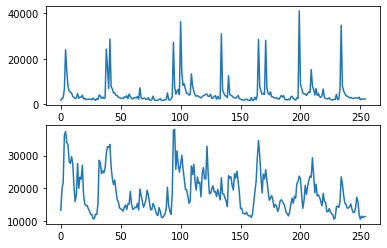

In [ ]:
import tqdm
import copy

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr = desc_lr, betas=(beta1, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr = gen_lr, betas=(beta1, 0.999))
criterion = torch.nn.BCELoss()
deq_d = collections.deque(maxlen = avg_t)
deq_g = collections.deque(maxlen = avg_t)
mean_d = []
mean_g = []
#ref_batch = next(iter(data_loader))
ref_batch = getNoise(batch_size).to(device)

def saveWeights(i):
    torch.save(generator.state_dict(), 'gen_'+str(i)+'.pt')
    torch.save(discriminator.state_dict(), 'disc_'+str(i)+'.pt')

def loadWeights(i = 0):
    if i == 0:
        generator.load_state_dict(torch.load('gen.pt'))
        discriminator.load_state_dict(torch.load('disc.pt'))
    else:
        generator.load_state_dict(torch.load('gen_'+str(i)+'.pt'))
        discriminator.load_state_dict(torch.load('disc_'+str(i)+'.pt'))

def smooth_ones_target(size):
    data = Variable(torch.ones(size, 1) * 0.9)
    return data

def ones_target(size):
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    data = Variable(torch.zeros(size, 1))
    return data
'''
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = criterion(prediction_real.cpu(), smooth_ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = criterion(prediction_fake.cpu(), zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake

def unrolled_train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = criterion(prediction_real.cpu(), smooth_ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = criterion(prediction_fake.cpu(), zeros_target(N))
    error_fake.backward(create_graph=True)
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake

def train_generator(optimizer, fake_data):
    N = fake_data.size(0)    # Reset gradients
    optimizer.zero_grad()    # Sample noise and generate fake data
    prediction = discriminator(fake_data)    # Calculate error and backpropagate
    error = criterion(prediction.cpu(), ones_target(N))
    error.backward()    # Update weights with gradients
    optimizer.step()    # Return error
    return error

def unrolled_train_generator(optimizer, real_data):
    N = real_data.size(0)
    optimizer.zero_grad()    # Sample noise and generate fake data
    noise = getNoise(N).to(device)
    for i in range(unrolled_steps):
      with torch.no_grad():
        fake_data = generator(noise)
      unrolled_train_discriminator(d_optimizer, real_data, fake_data)
    fake_data = generator(noise)
    prediction = discriminator(fake_data)    # Calculate error and backpropagate
    error = criterion(prediction.cpu(), ones_target(N))
    error.backward()    # Update weights with gradients
    optimizer.step()    # Return error
    return error

def unrolled_train_generator_with_feature_extraction(optimizer, real_data):
    N = real_data.size(0)
    optimizer.zero_grad()    # Sample noise and generate fake data
    noise = getNoise(N).to(device)
    for i in range(unrolled_steps):
      with torch.no_grad():
        fake_data = generator(noise)
      unrolled_train_discriminator(d_optimizer, real_data, fake_data)
    fake_data = generator(noise)
    prediction, features_fake = discriminator.forward_with_feature_extraction(fake_data)
    prediction, features_real = discriminator.forward_with_feature_extraction(real_data)
    error = ((features_fake.cpu().mean(dim=0) - features_real.detach().cpu().mean(dim=0))**2).mean()
    error.backward()    # Update weights with gradients
    optimizer.step()    # Return error
    return error
'''

def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = criterion(prediction_real.cpu(), smooth_ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = criterion(prediction_fake.cpu(), zeros_target(N))
    error_avg = weights_historical_avergaging_loss(discriminator, deq_d, avg_t, mean_d)
    if torch.isnan(error_avg).any() == False:
      error_fake += error_avg
    error_fake.backward()
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake

def unrolled_train_discriminator(optimizer, real_data, fake_data, deq_copy, mean_copy):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = criterion(prediction_real.cpu(), smooth_ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = criterion(prediction_fake.cpu(), zeros_target(N))
    error_avg = weights_historical_avergaging_loss(discriminator, deq_copy, avg_t, mean_copy)
    if torch.isnan(error_avg).any() == False:
      error_fake += error_avg
    error_fake.backward(create_graph=True)
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake

def train_generator(optimizer, fake_data):
    N = fake_data.size(0)    # Reset gradients
    optimizer.zero_grad()    # Sample noise and generate fake data
    prediction = discriminator(fake_data)    # Calculate error and backpropagate
    error = criterion(prediction.cpu(), ones_target(N))
    error.backward()    # Update weights with gradients
    optimizer.step()    # Return error
    return error

def unrolled_train_generator(optimizer, real_data, deq_copy):
    N = real_data.size(0)
    optimizer.zero_grad()    # Sample noise and generate fake data
    noise = getNoise(N).to(device)
    for i in range(unrolled_steps):
      with torch.no_grad():
        fake_data = generator(noise)
      unrolled_train_discriminator(d_optimizer, real_data, fake_data, deq_copy)
    fake_data = generator(noise)
    prediction = discriminator(fake_data)    # Calculate error and backpropagate
    error = criterion(prediction.cpu(), ones_target(N))
    error.backward()    # Update weights with gradients
    optimizer.step()    # Return error
    return error

def unrolled_train_generator_with_feature_extraction(optimizer, real_data, deq_copy, mean_copy):
    N = real_data.size(0)
    optimizer.zero_grad()    # Sample noise and generate fake data
    noise = getNoise(N).to(device)
    for i in range(unrolled_steps):
      with torch.no_grad():
        fake_data = generator(noise)
      unrolled_train_discriminator(d_optimizer, real_data, fake_data, deq_copy, mean_copy)
    fake_data = generator(noise)
    prediction, features_fake = discriminator.forward_with_feature_extraction(fake_data)
    prediction, features_real = discriminator.forward_with_feature_extraction(real_data)
    error = ((features_fake.cpu().mean(dim=0) - features_real.detach().cpu().mean(dim=0))**2).mean()
    error_avg = weights_historical_avergaging_loss(generator, deq_g, avg_t, mean_g)
    if torch.isnan(error_avg).any() == False:
      error += error_avg
    error.backward()    # Update weights with gradients
    optimizer.step()    # Return error
    return error

'''
def weights_historical_avergaging_loss(model, deq, t):
    curr_weights = list([p.cpu().data for p in model.parameters() if p.requires_grad])
    #curr_weights = model.named_parameters()
    if len(deq) > t/2:
        #print(curr_weights)
        #distance = torch.Tensor(torch.abs(torch.Tensor(torch.mean(deq, dim = 0) - curr_weights)))
        distance = 0
        mean = [torch.zeros_like(curr_weights[i]) for i in range(len(curr_weights))]
        for i in range(len(deq)):
          for j in range(len(curr_weights)):
            mean[j] += deq[i][j]
        for j in range(len(curr_weights)):
          mean[j] /= len(deq)
        for i in range(len(curr_weights)):
          distance += torch.sum(torch.abs(mean[i] - curr_weights[i]))
    else:
        distance = torch.Tensor([np.nan])
    curr_weights = [weight.detach() for weight in curr_weights]
    deq.append(curr_weights)
    return distance
'''
def weights_historical_avergaging_loss(model, deq, t, mean):
    curr_weights = list([p.cpu().data for p in model.parameters() if p.requires_grad])
    if len(deq) > t/2:
        distance = 0
        for i in range(len(curr_weights)):
          distance += torch.sum(torch.abs(mean[i] - curr_weights[i]))
    else:
        distance = torch.Tensor([np.nan])
    curr_weights = [weight.detach() for weight in curr_weights]
    if len(deq) < t:
      deq.append(curr_weights)
      mean.clear()
      mean.extend([torch.zeros_like(curr_weights[i]) for i in range(len(curr_weights))])
      for i in range(len(deq)):
        for j in range(len(curr_weights)):
          mean[j] += deq[i][j]
      for j in range(len(curr_weights)):
        mean[j] /= len(deq)
    else:
      popout = deq[0]
      popin = curr_weights
      for i in range(len(curr_weights)):
          mean[i] += (popin[i] - popout[i]) / len(deq)
      deq.append(curr_weights)
    return distance


def train(num_epochs):
  d_loss_history = []
  g_loss_history = []
  for epoch in tqdm.trange(num_epochs):
      g_epoch_loss = []
      d_epoch_loss = []
      for real_batch in data_loader:
          N = real_batch.size(0)        # 1. Train Discriminator
          real_data = Variable(real_batch).to(device)        # Generate fake data and detach 
          # (so gradients are not calculated for generator)
          fake_data = generator(getNoise(N).to(device)).detach()        # Train D
          d_loss = train_discriminator(d_optimizer, real_data, fake_data)
          d_epoch_loss.append(d_loss.detach().numpy())

          # 2. Train Generator        # Generate fake data
          fake_data = generator(getNoise(N).to(device))        # Train G
          g_loss = train_generator(g_optimizer, fake_data)
          g_epoch_loss.append(g_loss.detach().numpy())
      d_loss_history.append(np.mean(d_epoch_loss))
      g_loss_history.append(np.mean(g_epoch_loss))
  saveWeights()

def unrolled_train(num_epochs, unrolled_steps):
  d_loss_history = []
  g_loss_history = []
  for epoch in tqdm.trange(num_epochs):
      g_epoch_loss = []
      d_epoch_loss = []
      for real_batch in data_loader:
          N = real_batch.size(0)        # 1. Train Discriminator
          real_data = Variable(real_batch).to(device)        # Generate fake data and detach 
          # (so gradients are not calculated for generator)
          fake_data = generator(getNoise(N).to(device)).detach()        # Train D

          d_loss = train_discriminator(d_optimizer, real_data, fake_data)
          d_epoch_loss.append(d_loss.detach().numpy())
          
          # 2. Train Generator        # Generate fake data
          backup = discriminator.state_dict()                  #save discriminator 
          deq_backup = deq_d.copy()
          mean_backup = copy.deepcopy(mean_d)
          g_loss = unrolled_train_generator_with_feature_extraction(g_optimizer, real_data, deq_backup, mean_backup)
          g_epoch_loss.append(g_loss.detach().numpy())
          discriminator.load_state_dict(backup)                #load discriminator
      d_loss_history.append(np.mean(d_epoch_loss))
      g_loss_history.append(np.mean(g_epoch_loss))
      if (epoch % 10 == 0 or epoch == num_epochs - 1) and epoch != 0:
          saveWeights(epoch)
  
  plt.subplot(2, 1, 1)
  plt.plot(range(len(d_loss_history)), d_loss_history)

  plt.subplot(2, 1, 2)
  plt.plot(range(len(g_loss_history)), g_loss_history)

  plt.show()


#loadWeights(99)
unrolled_train(epochs, unrolled_steps)

Test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([3, 128, 32])
torch.Size([3, 128, 32])
torch.Size([3, 128, 32])
torch.Size([3, 128, 32])
torch.Size([3, 128, 32])
torch.Size([3, 128, 32])
torch.Size([3, 128, 32])
torch.Size([3, 128, 32])
torch.Size([3, 128, 32])
torch.Size([3, 128, 32])


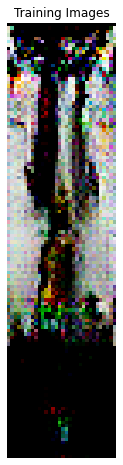

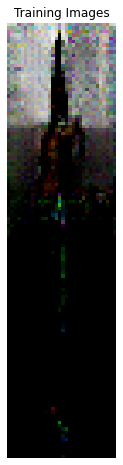

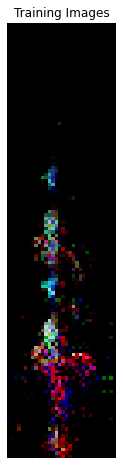

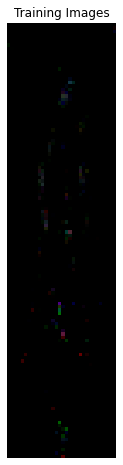

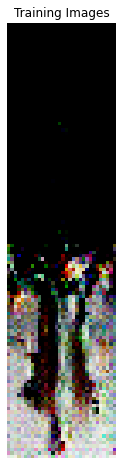

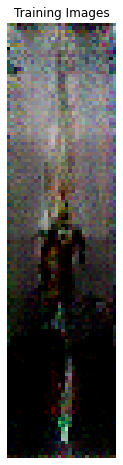

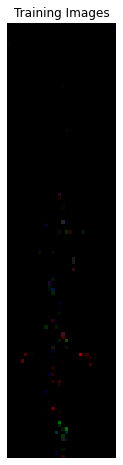

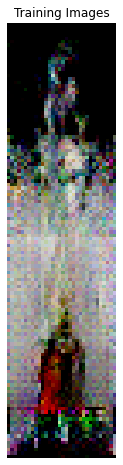

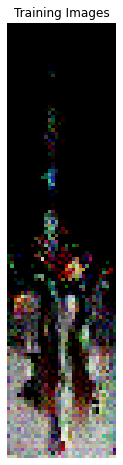

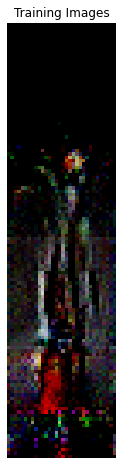

In [ ]:
import matplotlib.pyplot as plt

def loadWeightsFromDrive(i = 0):
    if i == 0:
        generator.load_state_dict(torch.load('./drive/My Drive/weights/gen.pt'))
        discriminator.load_state_dict(torch.load('./drive/My Drive/weights/disc.pt'))
    else:
        generator.load_state_dict(torch.load('./drive/My Drive/weights/gen_'+str(i)+'.pt'))
        discriminator.load_state_dict(torch.load('./drive/My Drive/weights/disc_'+str(i)+'.pt'))

def save_res_img(pic, name):
  
  print(pic.size())
  #pic = pic.view(512, 128, 3)
  tensor_to_pil = transforms.ToPILImage()(pic)
  tensor_to_pil.save(name)
  
  plt.figure(figsize=(8,8))
  plt.axis("off")
  plt.title("Training Images")
  plt.imshow(pic.permute(1,2,0))



def getPics(count):
  noise = getNoise(count).to(device)
  pics = generator(noise).detach().cpu()
  for i in range(len(pics)):
    save_res_img(pics[i], str(i)+'.png')



loadWeights(70)
getPics(10)

Archive generated dataset

In [ ]:
from zipfile import ZipFile
import os
from os.path import basename
# create a ZipFile object
with ZipFile('ds_swords.7z', 'w') as zipObj:
   # Iterate over all the files in directory
   for folderName, subfolders, filenames in os.walk('./ds_swords'):
       for filename in filenames:
           #create complete filepath of file in directory
           filePath = os.path.join(folderName, filename)
           # Add file to zip
           zipObj.write(filePath, basename(filePath))

Misc

In [ ]:
import torch
a = torch.sqrt(torch.Tensor([[1,10,100],[100,29,1]]))
print(a**2)

tensor([[  1.,  10., 100.],
        [100.,  29.,   1.]])
